# Packages

In [1]:
import pandas as pd
import polars as pl
import polars.selectors as cs
import numpy as np
import plotnine as pn
import matplotlib.pyplot as plt
from mizani.formatters import comma_format, custom_format, currency_format, percent_format
from IPython.display import clear_output, display
import os
import glob
from tqdm.notebook import tqdm
import itertools
import yaml
import matplotlib.font_manager as fm
import matplotlib as mpl
from matplotlib import rc
import time

# OpenMeteo API
import openmeteo_requests
import requests_cache
from retry_requests import retry

# ENTSOE
from entsoe import EntsoePandasClient, EntsoeRawClient

rc('text', usetex=False)

jama_colour = [
    "#374e55",
    "#df8f44",
    "#00a1d5",
    "#b24745",
    "#79af97",
]

pd.set_option("display.max.columns", 500)
pd.set_option("display.max.columns", 500)


theme_academic = pn.theme(
    text=pn.element_text(family="Latin Modern Roman"),
    plot_title=pn.element_text(weight="bold", size=14, ha="center"),
    legend_text=pn.element_text(size=9),  # Smaller font for legend items
    panel_background=pn.element_rect(fill="white"),  # Clean white background
    panel_border=pn.element_rect(color="grey", size=0.5),
    axis_ticks=pn.element_line(color="grey"),
    panel_grid_major=pn.element_line(color="grey", size=0.1),
    panel_grid_minor=pn.element_line(color="grey", size=0.1),
    legend_background=pn.element_rect(fill="white", color=None),
    legend_key=pn.element_rect(fill="white", color=None),
    plot_margin=0.02,
    figure_size=(6, 4),  # Set default figure size (width, height in inches)
)

%matplotlib inline

# Raw Data

## Swissgrid Energiestatistik

In [64]:
energieuebersicht_paths = [
    path for path in os.listdir("../0_data/raw/") if "EnergieUebersicht" in path
]

In [ ]:
load_dfs = []

for path in tqdm(energieuebersicht_paths):
    df_tmp = (
        pl.read_excel(
            source=f"../0_data/raw/{path}",
            sheet_name="Zeitreihen0h15",
        )
        .select(pl.nth(0), pl.nth(1))
        .tail(-1)
    )

    df_tmp.columns = ["datetime", "kWh"]

    df_tmp = df_tmp.with_columns(
        datetime=(
            pl.col("datetime").str.to_datetime() - pd.Timedelta(15, unit="minutes")
        ),
        kWh=pl.col("kWh").cast(pl.Float64),
    ).sort("datetime")

    load_dfs.append(df_tmp)

In [ ]:
load = pl.concat(load_dfs, how="vertical").sort("datetime")
load.head()

In [14]:
load.to_pandas().to_csv("../0_data/preprocessed/load.csv", index=False)

## OpenMeteo API

[API Link](https://open-meteo.com/en/docs/historical-weather-api)

### Pull the raw data

In [ ]:
cities = pd.DataFrame(
    {
        "name": [
            "Zurich",
            "Geneva",
            "Basel",
            "Bern",
            "St. Gallen",
            "Lugano",
            "Sion",
        ],
        "latitude": [
            47.3769,
            46.2044,
            47.5596,
            46.948,
            47.4245,
            46.0037,
            46.2331,
        ],
        "longitude": [
            8.5417,
            6.1432,
            7.5886,
            7.4474,
            9.3767,
            8.9511,
            7.3606,
        ],
    }
)

cities

In [16]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession(".cache", expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"

In [ ]:
for idx, city in cities.iterrows():
    params = {
        "latitude": city["latitude"],
        "longitude": city["longitude"],
        "start_date": "2009-01-01",
        "end_date": "2024-10-10",
        "hourly": [
            "temperature_2m",
            "relative_humidity_2m",
            "dew_point_2m",
            "apparent_temperature",
            "precipitation",
            "rain",
            "snowfall",
            "snow_depth",
            "cloud_cover",
            "wind_speed_10m",
            "wind_speed_100m",
            "wind_direction_10m",
            "wind_direction_100m",
            "wind_gusts_10m",
            "soil_temperature_0_to_7cm",
            "soil_temperature_7_to_28cm",
            "soil_temperature_28_to_100cm",
            "soil_temperature_100_to_255cm",
            "soil_moisture_0_to_7cm",
            "soil_moisture_7_to_28cm",
            "soil_moisture_28_to_100cm",
            "soil_moisture_100_to_255cm",
            "shortwave_radiation",
        ],
        "timezone": "Europe/Berlin",
    }
    responses = openmeteo.weather_api(url, params=params)

    # Process first location. Add a for-loop for multiple locations or weather models
    response = responses[0]
    print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
    print(f"Elevation {response.Elevation()} m asl")
    print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
    print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

    # Process hourly data. The order of variables needs to be the same as requested.
    hourly = response.Hourly()
    hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
    hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
    hourly_dew_point_2m = hourly.Variables(2).ValuesAsNumpy()
    hourly_apparent_temperature = hourly.Variables(3).ValuesAsNumpy()
    hourly_precipitation = hourly.Variables(4).ValuesAsNumpy()
    hourly_rain = hourly.Variables(5).ValuesAsNumpy()
    hourly_snowfall = hourly.Variables(6).ValuesAsNumpy()
    hourly_snow_depth = hourly.Variables(7).ValuesAsNumpy()
    hourly_cloud_cover = hourly.Variables(8).ValuesAsNumpy()
    hourly_wind_speed_10m = hourly.Variables(9).ValuesAsNumpy()
    hourly_wind_speed_100m = hourly.Variables(10).ValuesAsNumpy()
    hourly_wind_direction_10m = hourly.Variables(11).ValuesAsNumpy()
    hourly_wind_direction_100m = hourly.Variables(12).ValuesAsNumpy()
    hourly_wind_gusts_10m = hourly.Variables(13).ValuesAsNumpy()
    hourly_soil_temperature_0_to_7cm = hourly.Variables(14).ValuesAsNumpy()
    hourly_soil_temperature_7_to_28cm = hourly.Variables(15).ValuesAsNumpy()
    hourly_soil_temperature_28_to_100cm = hourly.Variables(16).ValuesAsNumpy()
    hourly_soil_temperature_100_to_255cm = hourly.Variables(17).ValuesAsNumpy()
    hourly_soil_moisture_0_to_7cm = hourly.Variables(18).ValuesAsNumpy()
    hourly_soil_moisture_7_to_28cm = hourly.Variables(19).ValuesAsNumpy()
    hourly_soil_moisture_28_to_100cm = hourly.Variables(20).ValuesAsNumpy()
    hourly_soil_moisture_100_to_255cm = hourly.Variables(21).ValuesAsNumpy()
    hourly_shortwave_radiation = hourly.Variables(22).ValuesAsNumpy()

    hourly_data = {
        "date": pd.date_range(
            start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
            end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=hourly.Interval()),
            inclusive="left",
        )
    }
    hourly_data["temperature_2m"] = hourly_temperature_2m
    hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
    hourly_data["dew_point_2m"] = hourly_dew_point_2m
    hourly_data["apparent_temperature"] = hourly_apparent_temperature
    hourly_data["precipitation"] = hourly_precipitation
    hourly_data["rain"] = hourly_rain
    hourly_data["snowfall"] = hourly_snowfall
    hourly_data["snow_depth"] = hourly_snow_depth
    hourly_data["cloud_cover"] = hourly_cloud_cover
    hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
    hourly_data["wind_speed_100m"] = hourly_wind_speed_100m
    hourly_data["wind_direction_10m"] = hourly_wind_direction_10m
    hourly_data["wind_direction_100m"] = hourly_wind_direction_100m
    hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m
    hourly_data["soil_temperature_0_to_7cm"] = hourly_soil_temperature_0_to_7cm
    hourly_data["soil_temperature_7_to_28cm"] = hourly_soil_temperature_7_to_28cm
    hourly_data["soil_temperature_28_to_100cm"] = hourly_soil_temperature_28_to_100cm
    hourly_data["soil_temperature_100_to_255cm"] = hourly_soil_temperature_100_to_255cm
    hourly_data["soil_moisture_0_to_7cm"] = hourly_soil_moisture_0_to_7cm
    hourly_data["soil_moisture_7_to_28cm"] = hourly_soil_moisture_7_to_28cm
    hourly_data["soil_moisture_28_to_100cm"] = hourly_soil_moisture_28_to_100cm
    hourly_data["soil_moisture_100_to_255cm"] = hourly_soil_moisture_100_to_255cm
    hourly_data["shortwave_radiation"] = hourly_shortwave_radiation

    hourly_dataframe = pd.DataFrame(data=hourly_data)
    hourly_dataframe.to_csv(
        f"../0_data/raw/weather_data_{city['name']}.csv", index=False
    )

    print(f"{city['name']} done... sleeping to prevent timeout")
    time.sleep(90)

### Aggregate to a single file

In [50]:
weather_paths = [path for path in os.listdir("../0_data/raw/") if "weather" in path]

weather_paths

['weather_data_Basel.csv',
 'weather_data_Bern.csv',
 'weather_data_Geneva.csv',
 'weather_data_Lugano.csv',
 'weather_data_Sion.csv',
 'weather_data_St. Gallen.csv',
 'weather_data_Zurich.csv']

In [51]:
weather_dfs = []

for path in weather_paths:

    weather_city = path.split(".")[0].split("_")[-1]

    weather_df = (
        pl.read_csv(f"../0_data/raw/{path}", try_parse_dates=True)
        .with_columns(pl.selectors.exclude("date").name.prefix(f"{weather_city}_"))
        .select("date", pl.selectors.contains(weather_city))
    )

    weather_dfs.append(weather_df)

In [54]:
result_df = weather_dfs[0]

for df in weather_dfs[1:]:
    result_df = result_df.join(df, on="date", how="left")

In [55]:
result_df.glimpse()

Rows: 138288
Columns: 162
$ date                                 <datetime[μs, UTC]> 2008-12-31 22:00:00+00:00, 2008-12-31 23:00:00+00:00, 2009-01-01 00:00:00+00:00, 2009-01-01 01:00:00+00:00, 2009-01-01 02:00:00+00:00, 2009-01-01 03:00:00+00:00, 2009-01-01 04:00:00+00:00, 2009-01-01 05:00:00+00:00, 2009-01-01 06:00:00+00:00, 2009-01-01 07:00:00+00:00
$ Basel_temperature_2m                               <f64> -1.1465, -1.4965, -1.8464999, -1.2965, -1.1465, -1.5465, -1.4965, -1.3965, -2.4965, -1.5965
$ Basel_relative_humidity_2m                         <f64> 95.69214, 94.97623, 94.96198, 96.03991, 96.398476, 96.38674, 95.32749, 94.63044, 94.23078, 92.88698
$ Basel_dew_point_2m                                 <f64> -1.7465, -2.1965, -2.5465, -1.8464999, -1.6465, -2.0465, -2.1465, -2.1465, -3.2965, -2.5965
$ Basel_apparent_temperature                         <f64> -3.8328483, -4.269863, -4.892221, -4.3226614, -4.0807962, -4.5546722, -4.456135, -4.3716264, -5.6152325, -4.773083
$ Basel_pre

In [69]:
result_df.to_pandas().to_csv("../0_data/preprocessed/weather.csv", index=False)

## Balance Prices Swissgrid

In [4]:
be_paths = [path for path in os.listdir("../0_data/raw/") if "balance" in path]
be_paths.sort()

In [5]:
be_paths[0]

'swissgrid-prices-for-balance-energy-240301-240401.xlsx'

In [ ]:
dfs = []

for path in tqdm(be_paths):
    df = pd.read_excel(f"../0_data/raw/{path}", skiprows=11, usecols=[0, 1, 2]).head(-6)
    df.columns = ["datetime", "long_ct_kWh", "short_ct_kWh"]
    dfs.append(df)

In [ ]:
balance_prices = (
    pd.concat(dfs, axis=0)
    .reset_index(drop=True)
    .assign(
        datetime=lambda x: pd.to_datetime(x["datetime"], format="%d.%m.%Y %H:%M:%S")
    )
    .sort_values("datetime")
    .reset_index(drop=True)
    .drop_duplicates()
)

balance_prices.head()

In [67]:
balance_prices.to_csv("../0_data/preprocessed/balance_energy_price.csv", index=False)

## ENTSO-E

In [3]:
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)

client = EntsoePandasClient(api_key=config["entsoe"])

### Day-Ahead Spot Price

In [7]:
start = pd.Timestamp("20150101", tz="Europe/Brussels")
end = pd.Timestamp("20241001", tz="Europe/Brussels")


data = client.query_day_ahead_prices(
    country_code="CH",
    start=start,
    end=end,
    resolution="60min",
)

In [ ]:
df_out = pd.DataFrame(data, columns=["da_spot_ch_eur_mwh"]).reset_index(names="date")
df_out

In [9]:
df_out.to_csv(f"../0_data/preprocessed/day_ahead_prices_ch.csv", index=False)

# Combining data sources

In [2]:
os.listdir("../0_data/preprocessed/")

['balance_energy_price.csv',
 'day_ahead_prices_ch.csv',
 'df_final.csv',
 'load.csv',
 'weather.csv']

Aggregating load data to hourly values

In [3]:
load = (
    pl.read_csv("../0_data/preprocessed/load.csv", try_parse_dates=True)
    .with_columns(pl.col("datetime").dt.truncate("1h"))
    .group_by("datetime")
    .agg(pl.col("kWh").mean() * 4)
    .sort("datetime")
)

In [5]:
weather = pl.read_csv(
    "../0_data/preprocessed/weather.csv", try_parse_dates=True
).with_columns(
    pl.col("date").dt.convert_time_zone("Europe/Zurich").dt.replace_time_zone(None)
)

In [6]:
df = (
    pl.DataFrame(
        {
            "datetime": pd.date_range(
                start=pl.read_csv(
                    "../0_data/preprocessed/load.csv", try_parse_dates=True
                )["datetime"].min(),
                end=pl.read_csv(
                    "../0_data/preprocessed/load.csv", try_parse_dates=True
                )["datetime"].max(),
                freq="1h",
            )
        }
    )
    .with_columns(pl.col("datetime").dt.cast_time_unit("us"))
    .join(
        load,
        on="datetime",
        how="left",
    )
    .join(
        weather,
        how="left",
        left_on="datetime",
        right_on="date",
    )
    .unique("datetime")
    .sort("datetime")
)

df.head()

datetime,kWh,Basel_temperature_2m,Basel_relative_humidity_2m,Basel_dew_point_2m,Basel_apparent_temperature,Basel_precipitation,Basel_rain,Basel_snowfall,Basel_snow_depth,Basel_cloud_cover,Basel_wind_speed_10m,Basel_wind_speed_100m,Basel_wind_direction_10m,Basel_wind_direction_100m,Basel_wind_gusts_10m,Basel_soil_temperature_0_to_7cm,Basel_soil_temperature_7_to_28cm,Basel_soil_temperature_28_to_100cm,Basel_soil_temperature_100_to_255cm,Basel_soil_moisture_0_to_7cm,Basel_soil_moisture_7_to_28cm,Basel_soil_moisture_28_to_100cm,Basel_soil_moisture_100_to_255cm,Basel_shortwave_radiation,Bern_temperature_2m,Bern_relative_humidity_2m,Bern_dew_point_2m,Bern_apparent_temperature,Bern_precipitation,Bern_rain,Bern_snowfall,Bern_snow_depth,Bern_cloud_cover,Bern_wind_speed_10m,Bern_wind_speed_100m,Bern_wind_direction_10m,…,St_wind_speed_10m,St_wind_speed_100m,St_wind_direction_10m,St_wind_direction_100m,St_wind_gusts_10m,St_soil_temperature_0_to_7cm,St_soil_temperature_7_to_28cm,St_soil_temperature_28_to_100cm,St_soil_temperature_100_to_255cm,St_soil_moisture_0_to_7cm,St_soil_moisture_7_to_28cm,St_soil_moisture_28_to_100cm,St_soil_moisture_100_to_255cm,St_shortwave_radiation,Zurich_temperature_2m,Zurich_relative_humidity_2m,Zurich_dew_point_2m,Zurich_apparent_temperature,Zurich_precipitation,Zurich_rain,Zurich_snowfall,Zurich_snow_depth,Zurich_cloud_cover,Zurich_wind_speed_10m,Zurich_wind_speed_100m,Zurich_wind_direction_10m,Zurich_wind_direction_100m,Zurich_wind_gusts_10m,Zurich_soil_temperature_0_to_7cm,Zurich_soil_temperature_7_to_28cm,Zurich_soil_temperature_28_to_100cm,Zurich_soil_temperature_100_to_255cm,Zurich_soil_moisture_0_to_7cm,Zurich_soil_moisture_7_to_28cm,Zurich_soil_moisture_28_to_100cm,Zurich_soil_moisture_100_to_255cm,Zurich_shortwave_radiation
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2009-01-01 00:00:00,6.9844e6,-1.4965,94.97623,-2.1965,-4.269863,0.1,0.0,0.07,0.06,57.899998,2.2768397,3.8268526,161.56496,228.81418,8.28,-0.7965,0.2535,3.2535,8.3535,0.477,0.468,0.47,0.47,0.0,-0.496,95.016594,-1.196,-3.113932,0.4,0.1,0.21,0.29,95.7,2.16,3.8939953,270.0,…,4.198285,8.350138,149.03632,172.56868,11.879999,1.0435,1.6435,4.0435004,7.3435,0.368,0.375,0.392,0.405,0.0,0.0005,95.03646,-0.6995,-2.498038,0.3,0.1,0.14,0.05,91.8,1.835647,4.896529,168.69011,162.89719,7.2,-0.5495,0.4505,2.9505,7.2505,0.4,0.376,0.406,0.41,0.0
2009-01-01 01:00:00,6.7564e6,-1.8465,94.96198,-2.5465,-4.892221,0.0,0.0,0.07,0.06,78.3,3.8268526,8.049845,221.18582,259.69522,9.0,-0.7965,0.2535,3.2535,8.3535,0.475,0.468,0.47,0.47,0.0,-1.046,94.99447,-1.746,-3.901534,0.2,0.1,0.07,0.29,64.799995,3.2599385,8.350138,263.6599,…,4.6800003,6.8399997,157.3801,180.0,11.159999,1.0435,1.6435,4.0435004,7.3435,0.367,0.375,0.391,0.405,0.0,-0.0495,95.381744,-0.6995,-2.496816,0.2,0.1,0.07,0.05,99.899994,1.484318,3.0547013,284.03625,224.9999,8.28,-0.5495,0.4505,2.9005,7.2505,0.399,0.376,0.406,0.41,0.0
2009-01-01 02:00:00,6.5171e6,-1.2965,96.03991,-1.8465,-4.322661,0.0,0.0,0.07,0.06,50.100002,4.3349743,9.826088,228.36655,261.57312,9.36,-0.7965,0.2535,3.2535,8.3535,0.473,0.468,0.47,0.47,0.0,-0.846,94.6542,-1.596,-3.819829,0.0,0.0,0.07,0.29,72.6,4.2136917,10.365251,289.9832,…,2.968636,6.297428,194.03627,210.96368,10.799999,1.0935,1.6935,4.0435004,7.3435,0.367,0.375,0.391,0.405,0.0,-0.3495,95.02247,-1.0495,-2.914122,0.3,0.1,0.14,0.06,99.9,1.9386592,5.0142193,291.80148,291.03757,8.64,-0.5495,0.4505,2.9005,7.2005,0.398,0.377,0.406,0.41,0.0
2009-01-01 03:00:00,6.2269e6,-1.1465,96.398476,-1.6465,-4.080796,0.0,0.0,0.07,0.06,69.3,3.8939953,8.766573,213.6901,250.82089,9.36,-0.7965,0.2535,3.2535,8.3535,0.472,0.468,0.47,0.47,0.0,-0.846,93.616,-1.746,-3.721354,0.0,0.0,0.0,0.29,58.499996,3.396233,10.086427,302.00534,…,3.2599385,5.991594,1

In [ ]:
df.with_columns(delta=pl.col("datetime") - pl.col("datetime").shift(1))[
    "delta"
].value_counts()

delta,count
duration[μs],u32
null,1
1h,137327


In [13]:
df.shape

(137328, 163)

<Axes: ylabel='Frequency'>

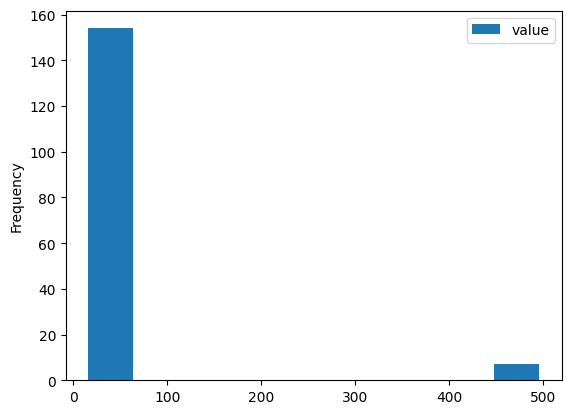

In [14]:
df.with_columns(pl.all().is_null()).sum().unpivot().filter(pl.col("value") > 0).sort(
    "value", descending=True
).to_pandas().plot(kind="hist")

In [15]:
df.to_pandas().to_csv("../0_data/preprocessed/df_final.csv", index=False)